In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/BT4012')


Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install transformers[torch] accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.2 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("nghuyong/ernie-2.0-base-en")
model = AutoModel.from_pretrained("nghuyong/ernie-2.0-base-en")

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# Import train and test data from CSV
train_df = pd.read_csv('X_train.csv')
test_df = pd.read_csv('X_test.csv')

In [ ]:
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [ ]:
train_df.head(5)

,0
0,Project Manager Project Manager will function...
1,Software Developer a.k.a CS Macgyver Urban Rob...
2,Assistant Managers / Supervisors Take Out Bran...
3,Lead Recruiter УУРРАА - технологическая компан...
4,. Net Developers In this role the Software De...


In [ ]:
test_df.head(5)

,0
0,Mail Clerk/Floater The best word to describe P...
1,Javascript / NODE.js Developer Capoo provide t...
2,Other Opportunities NOW: Pensions is a UK base...
3,Account Manager SpotSource Solutions LLC is a ...
4,Web Designer We’re looking for a web designer...


In [ ]:
y_train

,fraudulent
0,0
1,0
2,0
3,0
4,0
...,...
14299,0
14300,0
14301,0
14302,0


#ERNIE Model (Generating Embeddings)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

In [ ]:
# Function to encode texts to embeddings using ERNIE
def encode_texts(texts, model, tokenizer, batch_size=256, max_length=512):
    # Ensure model is on GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    # Break the texts into batches to avoid memory issues
    embeddings = []
    for i in range(0, len(texts), batch_size):
        # Process texts in the current batch
        batch_texts = texts[i:i+batch_size]
        # Tokenize batch texts with dynamic padding and truncation
        encoded_input = tokenizer(
            batch_texts,
            padding='longest',  # Dynamic padding to the longest sequence in the batch
            truncation=True,    # Truncate to max_length
            max_length=max_length,
            return_tensors='pt'
        ).to(device)

        # Generate embeddings with no gradient calculations
        with torch.no_grad():
            model_output = model(**encoded_input)

        # Pool the outputs into a single mean vector per batch item
        batch_embeddings = model_output.last_hidden_state.mean(dim=1)
        # Move embeddings to CPU and convert to numpy for further processing or storage
        embeddings.append(batch_embeddings.cpu().numpy())

    # Concatenate all batch embeddings into a single matrix
    embeddings = np.vstack(embeddings)

    return embeddings

In [ ]:
# Generate ERNIE embeddings for the training set
train_embeddings = encode_texts(train_df['0'].tolist(), model, tokenizer)

# Generate ERNIE embeddings for the test set
test_embeddings = encode_texts(test_df['0'].tolist(), model, tokenizer)

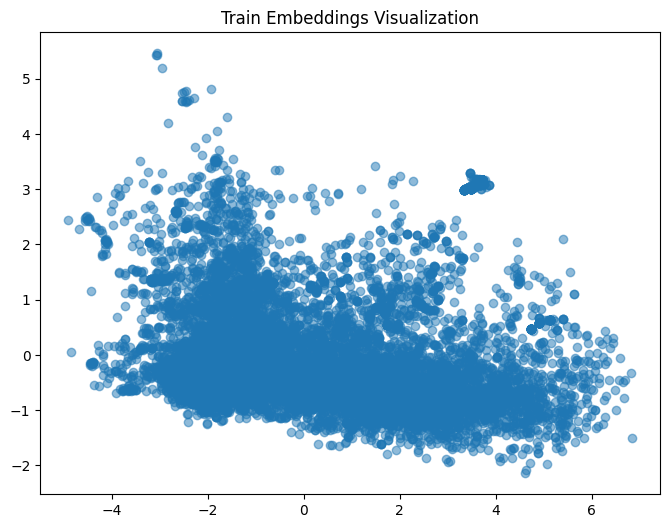

In [ ]:
# Visualize embeddings using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(train_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
plt.title('Train Embeddings Visualization')
plt.show()


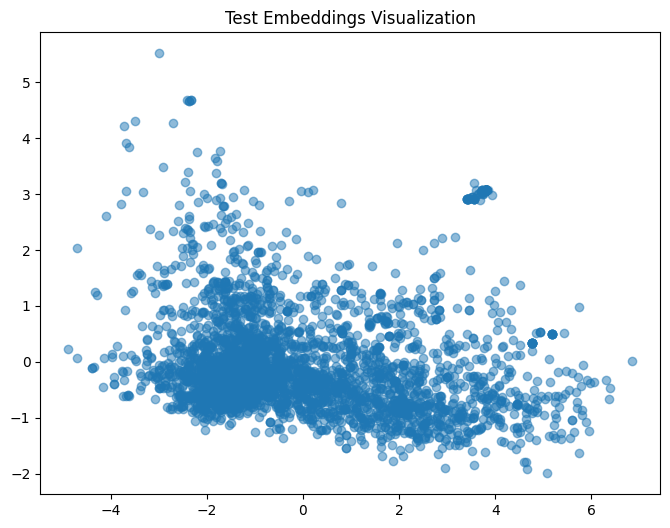

In [ ]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(test_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
plt.title('Test Embeddings Visualization')
plt.show()

##XG Boost


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay, roc_auc_score


XGBoost Model Evaluation on Test Set:


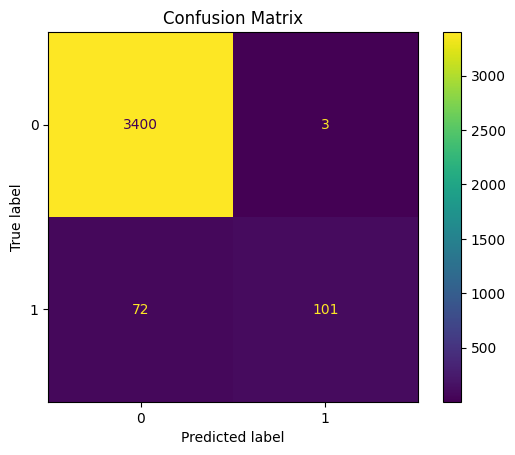

Accuracy: 0.9790
AUC: 0.9758

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.97      0.58      0.73       173

    accuracy                           0.98      3576
   macro avg       0.98      0.79      0.86      3576
weighted avg       0.98      0.98      0.98      3576



In [ ]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(random_state=4012)
xgb_model.fit(train_embeddings, y_train)

# Predict on the test data
y_pred_xgb = xgb_model.predict(test_embeddings)

# Predict probabilities on the test data
y_prob_xgb = xgb_model.predict_proba(test_embeddings)[:, 1]

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
classification_rep_xgb = classification_report(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# # F1 Score
# f1 = f1_score(y_test, y_pred_xgb)
# print(f'F1 Score: {f1:.4f}')

print("XGBoost Model Evaluation on Test Set:")
ConfusionMatrixDisplay(conf_matrix_xgb).plot()
plt.title("Confusion Matrix")
plt.show()

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"AUC: {auc_xgb:.4f}")
print("\nClassification Report:")
print(classification_rep_xgb)

XGBoost Model Evaluation on Training Set:


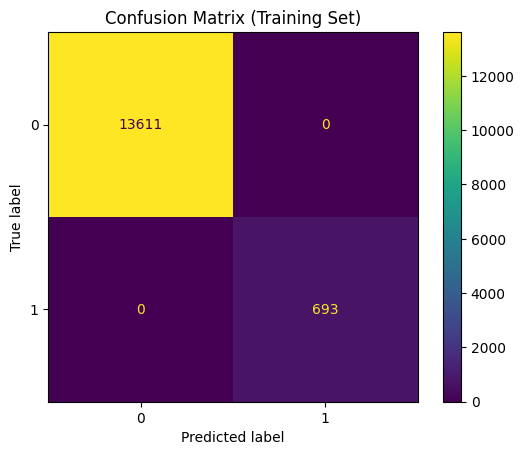

Accuracy (Training Set): 1.0000
AUC (Training Set): 1.0000

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13611
           1       1.00      1.00      1.00       693

    accuracy                           1.00     14304
   macro avg       1.00      1.00      1.00     14304
weighted avg       1.00      1.00      1.00     14304



In [ ]:
# Predict on the training data
y_pred_xgb_train = xgb_model.predict(train_embeddings)

# Predict probabilities on the training data
y_prob_xgb_train = xgb_model.predict_proba(train_embeddings)[:, 1]

# Evaluate the model on the training set
accuracy_xgb_train = accuracy_score(y_train, y_pred_xgb_train)
conf_matrix_xgb_train = confusion_matrix(y_train, y_pred_xgb_train)
classification_rep_xgb_train = classification_report(y_train, y_pred_xgb_train)
auc_xgb_train = roc_auc_score(y_train, y_prob_xgb_train)

# Print the XGBoost Model Evaluation for the training set
print("XGBoost Model Evaluation on Training Set:")
ConfusionMatrixDisplay(conf_matrix_xgb_train).plot()
plt.title("Confusion Matrix (Training Set)")
plt.show()

print(f"Accuracy (Training Set): {accuracy_xgb_train:.4f}")
print(f"AUC (Training Set): {auc_xgb_train:.4f}")
print("\nClassification Report (Training Set):")
print(classification_rep_xgb_train)


##SVM


In [ ]:
import time
from sklearn.svm import SVC

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Model Evaluation on Test Set:


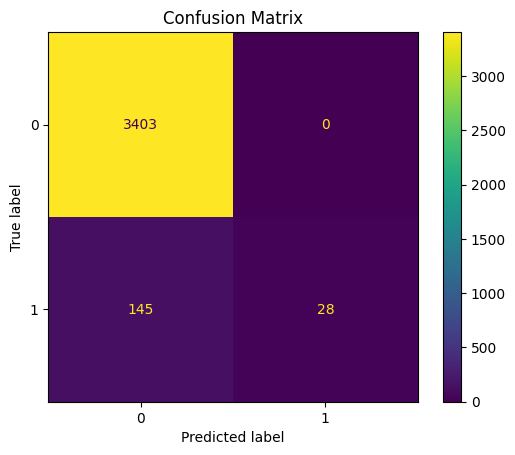

Duration of model training and prediction: 86.78 seconds
Accuracy: 0.9595
AUC: 0.9128

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3403
           1       1.00      0.16      0.28       173

    accuracy                           0.96      3576
   macro avg       0.98      0.58      0.63      3576
weighted avg       0.96      0.96      0.95      3576



In [ ]:
start_time = time.time()
# Initialize the SVM model
svm_model = SVC(random_state=4012, probability=True)

# Fit the SVM model on the training data
svm_model.fit(train_embeddings, y_train)

# Predict probabilities on the test data
y_prob_svm = svm_model.predict_proba(test_embeddings)[:, 1]

# Predict on the test data
y_pred_svm = svm_model.predict(test_embeddings)
end_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)
classification_rep = classification_report(y_test, y_pred_svm)
elapsed_time = end_time - start_time
auc = roc_auc_score(y_test, y_prob_svm)

# Plot the confusion matrix
print("SVM Model Evaluation on Test Set:")
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title("Confusion Matrix")
plt.show()

print(f"Duration of model training and prediction: {elapsed_time:.2f} seconds")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print("\nClassification Report:")
print(classification_rep)

SVM Model Evaluation on Training Set:


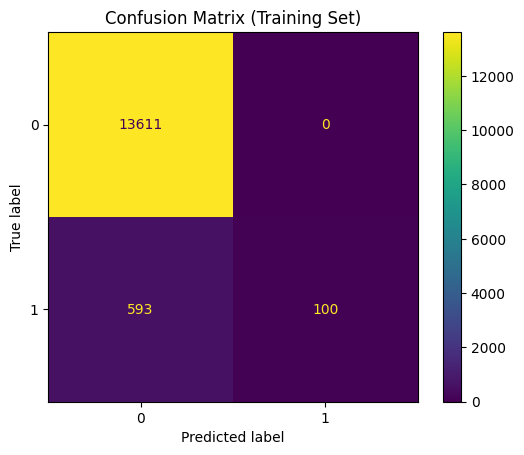

Duration of model training and prediction on training set: 28.47 seconds
Accuracy (Training Set): 0.9585
AUC (Training Set): 0.9445

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13611
           1       1.00      0.14      0.25       693

    accuracy                           0.96     14304
   macro avg       0.98      0.57      0.62     14304
weighted avg       0.96      0.96      0.94     14304



In [ ]:
# Time the prediction process
start_time_train = time.time()

# Predict on the training data
y_pred_svm_train = svm_model.predict(train_embeddings)

# Predict probabilities on the training data
y_prob_svm_train = svm_model.predict_proba(train_embeddings)[:, 1]

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train, y_pred_svm_train)
conf_matrix_train = confusion_matrix(y_train, y_pred_svm_train)
classification_rep_train = classification_report(y_train, y_pred_svm_train)
auc_train = roc_auc_score(y_train, y_prob_svm_train)

# Calculate the elapsed time for training set prediction
end_time_train = time.time()
elapsed_time_train = end_time_train - start_time_train

# Print the SVM Model Evaluation for the training set
print("SVM Model Evaluation on Training Set:")
ConfusionMatrixDisplay(conf_matrix_train).plot()
plt.title("Confusion Matrix (Training Set)")
plt.show()

print(f"Duration of model training and prediction on training set: {elapsed_time_train:.2f} seconds")
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print(f"AUC (Training Set): {auc_train:.4f}")
print("\nClassification Report (Training Set):")
print(classification_rep_train)


## Attempt at ERNIE for classification


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# Define the ERNIE model with a classification head
model = AutoModelForSequenceClassification.from_pretrained("nghuyong/ernie-2.0-base-en", num_labels=2)  # num_labels is the number of classes

# Prepare the training dataset
train_encodings = tokenizer(train_df['0'].tolist(), truncation=True, padding=True, max_length=512)
train_labels = y_train['fraudulent'].tolist()

# Prepare the validation dataset
test_encodings = tokenizer(test_df['0'].tolist(), truncation=True, padding=True, max_length=512)
test_labels = y_test['fraudulent'].tolist()

# Define a PyTorch dataset class
class ERNIEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset objects
train_dataset = ERNIEDataset(train_encodings, train_labels)
test_dataset = ERNIEDataset(test_encodings, test_labels)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train (fine-tune) the model
trainer.train()

# Evaluate the model
trainer.evaluate()


Some weights of ErnieForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-2.0-base-en and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.125200,0.194458


Epoch,Training Loss,Validation Loss
1,0.125200,0.194458
2,0.095300,0.095141
3,0.040000,0.087081


{'eval_loss': 0.08708050101995468,
 'eval_runtime': 116.6415,
 'eval_samples_per_second': 30.658,
 'eval_steps_per_second': 0.48,
 'epoch': 3.0}

In [ ]:
# Evaluate the model
results = trainer.evaluate()


ERNIE Model Evaluation on Training Set:


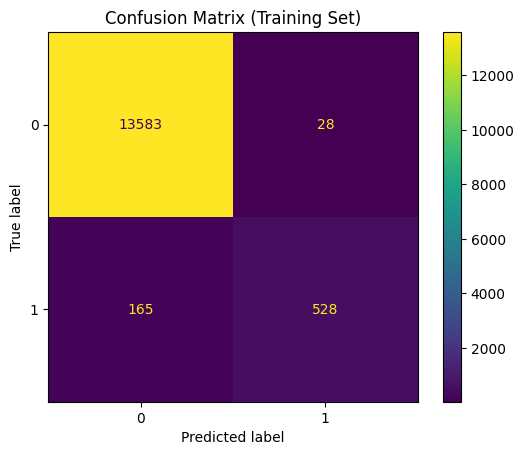


Metrics for Training Set:
Accuracy: 0.9865
AUC: 0.9588

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13611
           1       0.95      0.76      0.85       693

    accuracy                           0.99     14304
   macro avg       0.97      0.88      0.92     14304
weighted avg       0.99      0.99      0.99     14304



In [ ]:
# Predict on the training set
train_results = trainer.predict(train_dataset)

# Extract predictions and labels from the train_results
y_prob_ernie_train = torch.nn.functional.softmax(torch.tensor(train_results.predictions), dim=1)[:, 1].cpu().numpy()
y_pred_ernie_train = np.argmax(train_results.predictions, axis=1)

y_train_labels = y_train['fraudulent'].values

# Evaluate the model on the training set
accuracy_train = accuracy_score(y_train_labels, y_pred_ernie_train)
conf_matrix_train = confusion_matrix(y_train_labels, y_pred_ernie_train)
classification_rep_train = classification_report(y_train_labels, y_pred_ernie_train)
auc_train = roc_auc_score(y_train_labels, y_prob_ernie_train)

# Plot the confusion matrix for the training set
print("ERNIE Model Evaluation on Training Set:")
ConfusionMatrixDisplay(conf_matrix_train).plot()
plt.title("Confusion Matrix (Training Set)")
plt.show()

# Print metrics for the training set
print("\nMetrics for Training Set:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"AUC: {auc_train:.4f}")
print("\nClassification Report:")
print(classification_rep_train)


ERNIE Model Evaluation on Test Set:


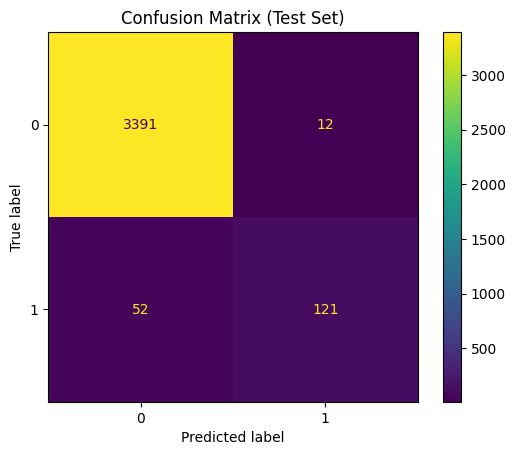

Metrics for Test Set:
Accuracy: 0.9821
AUC: 0.9460

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.91      0.70      0.79       173

    accuracy                           0.98      3576
   macro avg       0.95      0.85      0.89      3576
weighted avg       0.98      0.98      0.98      3576



In [ ]:
# Use trainer.predict to get the predictions
predict_results = trainer.predict(test_dataset)

# Extract predictions and labels from the predict_results
y_prob_ernie = torch.nn.functional.softmax(torch.tensor(predict_results.predictions), dim=1)[:, 1].cpu().numpy()
y_pred_ernie = np.argmax(predict_results.predictions, axis=1)

y_test_labels = y_test['fraudulent'].values

# Evaluate the model
accuracy = accuracy_score(y_test_labels, y_pred_ernie)
conf_matrix = confusion_matrix(y_test_labels, y_pred_ernie)
classification_rep = classification_report(y_test_labels, y_pred_ernie)
auc = roc_auc_score(y_test_labels, y_prob_ernie)

# Plot the confusion matrix
print("ERNIE Model Evaluation on Test Set:")
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

print("Metrics for Test Set:")
print(f"Accuracy: {accuracy :.4f}")
print(f"AUC: {auc:.4f}")
print("\nClassification Report:")
print(classification_rep)